In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm as tq
from numpy import vstack, sqrt
from sklearn.metrics import mean_squared_error
from google.colab import files
from statistics import mean


from functools import partial
from pylab import rcParams

import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary


%matplotlib inline

rcParams['figure.figsize'] = 24, 10


RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
torch.use_deterministic_algorithms(True)

In [3]:
num_datapoints = 256

k1 = 0.05
k2 = 0.002
k3 = 0.03
k4=0.001 

r_0 = 6
w_0 = 2

r = [0] * (num_datapoints)
w = [0] * (num_datapoints)


for i in range(num_datapoints):
    if i == 0: 
        r[i] = r_0
        w[i] = w_0
        continue

    dr = k1*r[i-1] - k2*r[i-1]*w[i-1]
    dw = -k3*w[i-1] + k4*r[i-1]*w[i-1]  
    r[i] = r[i-1] + dr
    w[i] = w[i-1] + dw 


In [4]:
r = torch.FloatTensor(r)
w = torch.FloatTensor(w)
t =  torch.range(1, num_datapoints)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  This is separate from the ipykernel package so we can avoid doing imports until


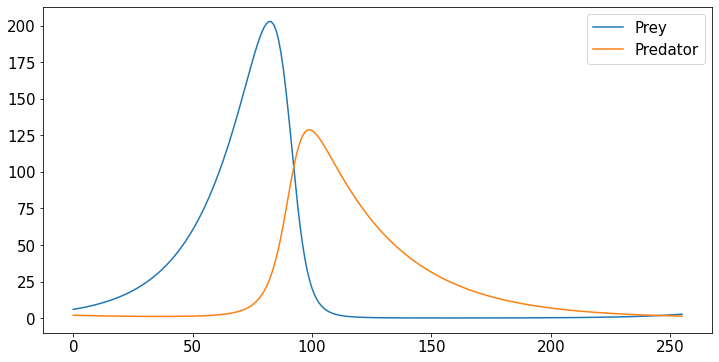

In [5]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 15
plt.plot(r, label="Prey")
plt.plot(w, label="Predator")
plt.legend()
plt.show()

In [6]:
from typing import Callable

import matplotlib.pyplot as plt
import torch 
from torch import nn

In [7]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 2)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

# nn_approximator_r = NNApproximator(4, 10)
# nn_approximator_w = NNApproximator(4, 10)
nn_approximator = NNApproximator(4, 10)

In [8]:
def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value_1 = f(nn, x)[:,0].reshape(-1,1)
    df_value_2 = f(nn, x)[:,1].reshape(-1,1) 
    # print(df_value_1[0:5], df_value_2[0:5])
    for _ in range(order):
        df_value_1 = torch.autograd.grad(
            df_value_1,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]
    for _ in range(order):
        df_value_2 = torch.autograd.grad(
            df_value_2,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]
    # print(df_value_1)
    return df_value_1, df_value_2

In [16]:
def compute_loss(
    nn: nn_approximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    preys_mse = (f(nn,x)[:,0] - r).pow(2).mean() 
    predators_mse =  (f(nn,x)[:,1] - 2).pow(2).mean()
    mse_loss = preys_mse + predators_mse

    preys_loss = df(nn, x)[0]  - (k1*f(nn,x)[:,0] - k2*f(nn, x)[:,0]*f(nn,x)[:,1])
    predators_loss = df(nn, x)[1]  - (- k3*f(nn,x)[:,1] + k4*f(nn,x)[:,0]*f(nn,x)[:,1])
    pde_loss = preys_loss + predators_loss

    ic = torch.Tensor([1.0])
    ic.requires_grad = True
    ic_loss_r = f(nn, ic)[0] - r_0
    ic_loss_w = f(nn, ic)[1]- w_0 
    ic_weight = 0.1
    pde_weight = 1.0
    mse_weight = 0.000
    final_loss = mse_weight*mse_loss + pde_weight*pde_loss.pow(2).mean() + ic_weight*ic_loss_r ** 2 + ic_weight*ic_loss_w ** 2
    print(final_loss.item(), mse_weight*mse_loss.item(), pde_weight*pde_loss.pow(2).mean().item(), (ic_weight*ic_loss_r ** 2).item(), (ic_weight*ic_loss_w ** 2).item())
    return final_loss


def train_model(
    nn: nn_approximator, 
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(loss)
            # break
            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)


In [17]:
def plot():
    fig, ax = plt.subplots()

    f_final_training = f(nn_approximator_trained, x)
    # f_final = f(nn_approximator_trained, x_eval)

    ax.scatter(x.detach().numpy(), f_final_training[:,0].reshape(-1,1).detach().numpy(), label="Preys", color="green")
    ax.scatter(x.detach().numpy(), f_final_training[:,1].reshape(-1,1).detach().numpy(), label="Predators", color="red")
    # ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")

    ax.set(title="Predators-Preys with PINN", xlabel="t", ylabel="Population")
    ax.legend()

    fig, ax = plt.subplots()
    ax.semilogy(loss_evolution)
    ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
    ax.legend()

    plt.show()

In [18]:
#x = time
x = torch.range(1, num_datapoints, requires_grad=True)
x = x.reshape(x.shape[0], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=10_000
)
plot()

Streaming output truncated to the last 5000 lines.
0.014313963241875172 0.0 0.01418971735984087 0.00011902255209861323 5.223561402090127e-06
0.014297387562692165 0.0 0.014173370786011219 0.00011881208047270775 5.205311936151702e-06
0.014280812814831734 0.0 0.014157023280858994 0.00011860179074574262 5.187094302527839e-06
0.014264251105487347 0.0 0.014140693470835686 0.00011838840146083385 5.168566076463321e-06
0.014247697778046131 0.0 0.01412437204271555 0.00011817520862678066 5.1504130169632845e-06
0.014231154695153236 0.0 0.014108060859143734 0.00011796221224358305 5.131950274517294e-06
0.014214623719453812 0.0 0.014091757126152515 0.0001177526792162098 5.114202849654248e-06
0.014198106713593006 0.0 0.01407547015696764 0.00011754006118280813 5.096145741845248e-06
0.014181598089635372 0.0 0.014059191569685936 0.00011732762504834682 5.07812001160346e-06
0.014165094122290611 0.0 0.01404291857033968 0.00011711538536474109 5.060126568423584e-06
0.014148609712719917 0.0 0.01402666047215461

Streaming output truncated to the last 5000 lines.
3.407809019088745 3.31665966796875 0.09109573066234589 1.964440889423713e-05 3.384229785297066e-05
3.407752752304077 3.31655322265625 0.09113968163728714 1.2552141015476082e-07 5.942173447692767e-05
3.40769624710083 3.316519287109375 0.09112217277288437 2.2212920157471672e-05 3.2333817216567695e-05
Epoch: 5000 - Loss: 3.407696
3.407640218734741 3.316408203125 0.0911702960729599 2.801471055136062e-09 6.158774340292439e-05
3.4075844287872314 3.316380126953125 0.09114807099103928 2.551879151724279e-05 3.0558487196685746e-05
3.407528877258301 3.316262939453125 0.0912012830376625 9.784707799553871e-08 6.427329935831949e-05
3.407473087310791 3.316241455078125 0.09117336571216583 2.9830087441951036e-05 2.847593350452371e-05
3.4074180126190186 3.316116943359375 0.09123276174068451 5.741005679738009e-07 6.762650446034968e-05
3.407363176345825 3.316103515625 0.0911979153752327 3.551576810423285e-05 2.6049045118270442e-05
3.407309055328369 3.3159

 0.0038706876803189516 0.0016799549339339137
3.2518653869628906 3.162062255859375 0.08441704511642456 0.0038197708781808615 0.0015660942299291492
3.252016544342041 3.15840576171875 0.08808577805757523 0.0038522572722285986 0.0016722438158467412
3.2518045902252197 3.162023681640625 0.08442085981369019 0.0038016384933143854 0.0015583480708301067
3.2519545555114746 3.15837060546875 0.08808566629886627 0.0038336936850100756 0.001664453186094761
3.251744508743286 3.1619853515625 0.0844247043132782 0.0037836080882698298 0.0015506118070334196
3.2518935203552246 3.158335693359375 0.08808553963899612 0.003815174801275134 0.0016567583661526442
3.251683235168457 3.1619462890625 0.0844285786151886 0.0037654447369277477 0.0015428760088980198
3.2518317699432373 3.15830078125 0.08808541297912598 0.003796642180532217 0.0016489651752635837


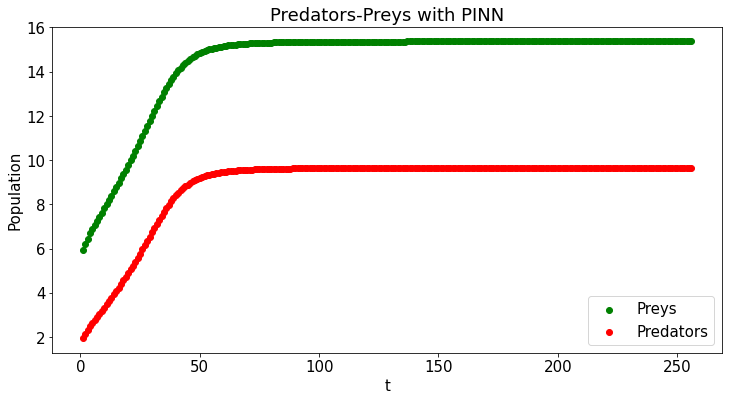

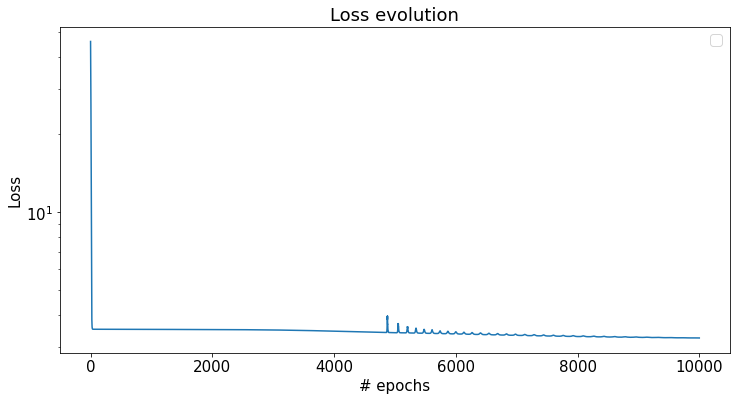

In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=10_000
)
plot()

Streaming output truncated to the last 5000 lines.
3.0616111755371094 3.061610107421875 0.0 2.893066266551614e-07 6.419304554583505e-07
3.0615322589874268 3.0615312500000003 0.0 2.882816261262633e-07 6.409757133951643e-07
3.0614538192749023 3.0614526367187502 0.0 2.893066266551614e-07 6.398309437827265e-07
3.0613749027252197 3.061373779296875 0.0 2.852175384759903e-07 6.400216534530045e-07
3.061296224594116 3.061295166015625 0.0 2.882816261262633e-07 6.386871973518282e-07
3.0612175464630127 3.061216552734375 0.0 2.821698217303492e-07 6.386871973518282e-07
3.0611395835876465 3.061138427734375 0.0 2.882816261262633e-07 6.373541054927045e-07
3.0610604286193848 3.061059326171875 0.0 2.8065210244676564e-07 6.379252681654179e-07
3.0609822273254395 3.060981201171875 0.0 2.852175384759903e-07 6.360224347190524e-07
3.060904026031494 3.06090283203125 0.0 2.7913847588934004e-07 6.364027740346501e-07
3.0608253479003906 3.06082421875 0.0 2.841998139047064e-07 6.34502214325039e-07
3.060746908187866 

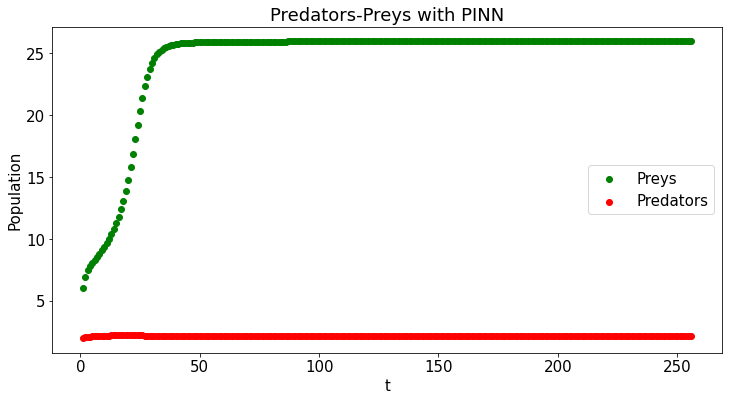

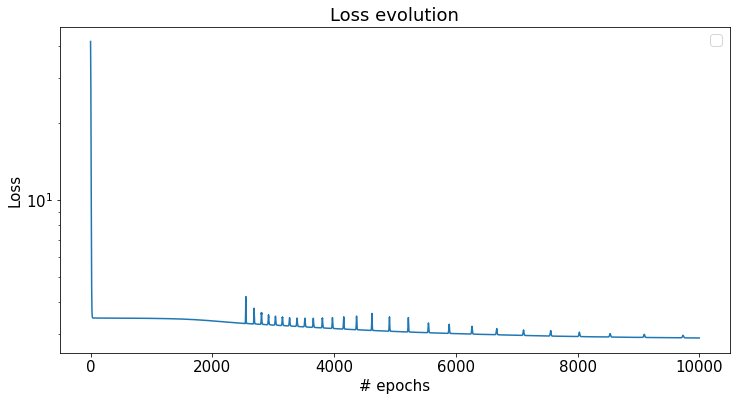

In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=10_000
)
plot()

Streaming output truncated to the last 5000 lines.
1.3844866752624512 6 0.29294466972351074 2 24.22028923034668 0.003288840875029564 21.302963256835938 2.9140379428863525
1.715082049369812 6 0.4368441104888916 2 20.808725357055664 0.004746479447931051 18.36052131652832 2.4434564113616943
2.074638843536377 6 0.5877204537391663 2 17.409645080566406 0.00665116123855114 15.40846061706543 1.994533658027649
2.45688533782959 6 0.7424956560134888 2 14.144026756286621 0.009048854932188988 12.553661346435547 1.5813171863555908
2.851484537124634 6 0.8972117900848389 2 11.141223907470703 0.011932842433452606 9.9131498336792 1.2161418199539185
3.245394706726074 6 1.0474834442138672 2 8.510366439819336 0.015228642150759697 7.587850093841553 0.9072877764701843
3.6250789165496826 6 1.1891047954559326 2 6.316600799560547 0.01879945956170559 5.640250205993652 0.6575510501861572
3.9789204597473145 6 1.318695068359375 2 4.571413040161133 0.02247381955385208 4.0847625732421875 0.4641764163970947
4.29889011

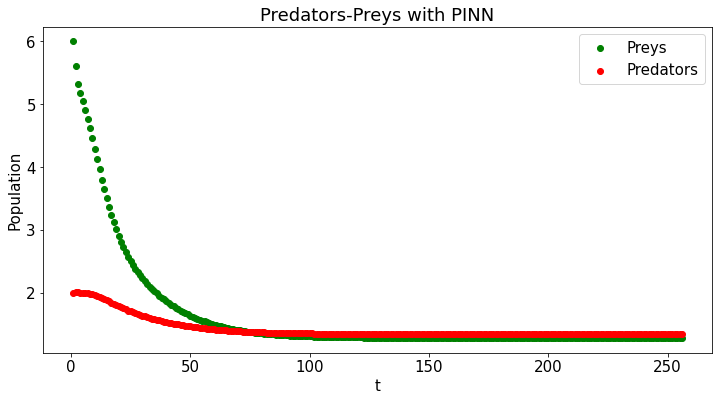

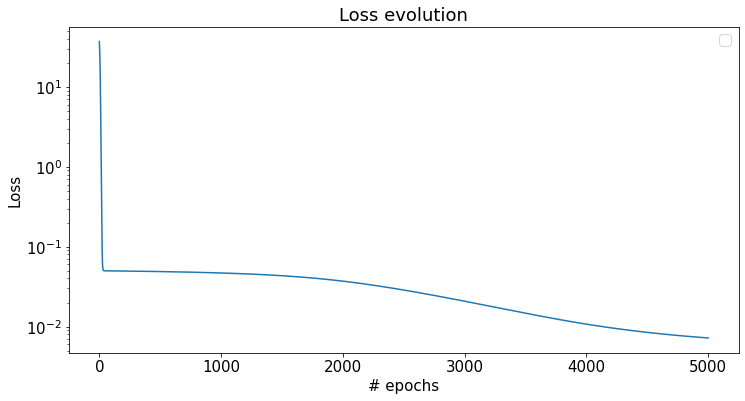

In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=5_000
)
plot()

Streaming output truncated to the last 5000 lines.
5.9993133544921875 6 2.000109910964966 2 0.0022855994757264853 0.002285115886479616 4.71482053399086e-07 1.208042021971778e-08
5.9993133544921875 6 2.000109910964966 2 0.0022854579146951437 0.0022849743254482746 4.71482053399086e-07 1.208042021971778e-08
5.9993133544921875 6 2.000110149383545 2 0.002285317052155733 0.002284833462908864 4.71482053399086e-07 1.2132886695326306e-08
5.9993133544921875 6 2.0001096725463867 2 0.002285175956785679 0.0022846923675388098 4.71482053399086e-07 1.2028067430946976e-08
Epoch: 15000 - Loss: 0.002285
5.9993133544921875 6 2.000110149383545 2 0.0022850350942462683 0.002284551504999399 4.71482053399086e-07 1.2132886695326306e-08
5.999314308166504 6 2.000110149383545 2 0.0022848930675536394 0.0022844108752906322 4.7017329052323475e-07 1.2132886695326306e-08
5.999313831329346 6 2.000109910964966 2 0.002284752670675516 0.002284269779920578 4.7082744458748493e-07 1.208042021971778e-08
5.999313831329346 6 2.0

5.999436378479004 6 2.0001168251037598 2 0.0017003945540636778 0.0017000632360577583 3.1766921892995015e-07 1.3648104868480004e-08
5.999436855316162 6 2.0001168251037598 2 0.001700297580100596 0.0016999668441712856 3.171319349348778e-07 1.3648104868480004e-08
5.999436378479004 6 2.0001168251037598 2 0.0017002021195366979 0.0016998708015307784 3.1766921892995015e-07 1.3648104868480004e-08
5.999436855316162 6 2.0001168251037598 2 0.0017001060768961906 0.0016997753409668803 3.171319349348778e-07 1.3648104868480004e-08
5.999436378479004 6 2.0001168251037598 2 0.001700010383501649 0.0016996790654957294 3.1766921892995015e-07 1.3648104868480004e-08
5.999436378479004 6 2.000117063522339 2 0.0016999138751998544 0.001699582440778613 3.1766921892995015e-07 1.3703868262382457e-08
5.999436378479004 6 2.0001168251037598 2 0.0016998178325593472 0.0016994865145534277 3.1766921892995015e-07 1.3648104868480004e-08
5.999436855316162 6 2.0001168251037598 2 0.0016997215570881963 0.001699390821158886 3.171

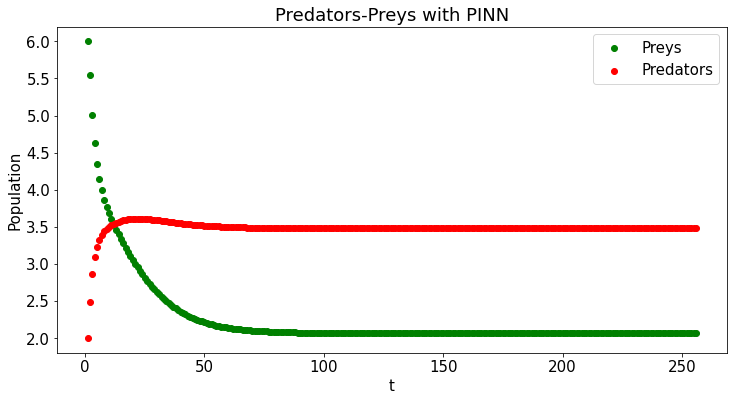

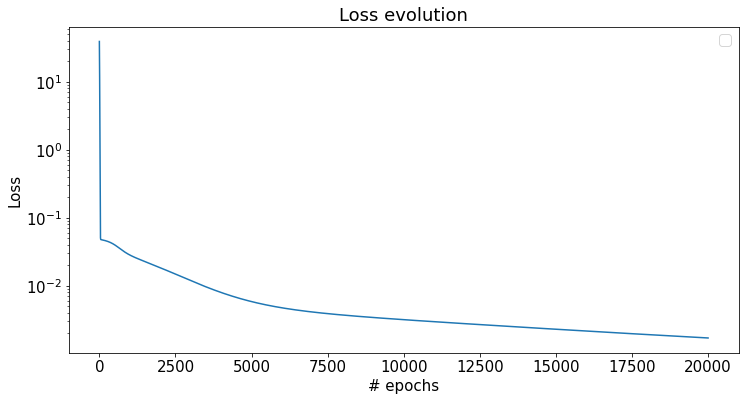

In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=20_000
)
plot()

Streaming output truncated to the last 5000 lines.
5.999325275421143 6 2.000391721725464 2 0.0023910650052130222 0.002390456502325833 4.552532573143253e-07 1.5344591020038933e-07
5.999324798583984 6 2.0003914833068848 2 0.0023910279851406813 0.0023904188128653914 4.558969521895051e-07 1.5325917956943158e-07
5.999324798583984 6 2.000391721725464 2 0.002390994457527995 0.002390385197941214 4.558969521895051e-07 1.5344591020038933e-07
5.999324798583984 6 2.000391960144043 2 0.0023909583687782288 0.002390348818153143 4.558969521895051e-07 1.536327545181848e-07
5.999325275421143 6 2.000391721725464 2 0.002390922512859106 0.002390313893556595 4.552532573143253e-07 1.5344591020038933e-07
Epoch: 15000 - Loss: 0.002391
5.999325275421143 6 2.0003914833068848 2 0.0023908866569399834 0.0023902782413642853 4.552532573143253e-07 1.5325917956943158e-07
5.999324798583984 6 2.000391960144043 2 0.002390851965174079 0.0023902424436528236 4.558969521895051e-07 1.536327545181848e-07
5.999324798583984 6 2.0

5.999438285827637 6 2.0003764629364014 2 0.00228194915689528 0.002281491906614974 3.1552281143376604e-07 1.4172434248393984e-07
5.99943733215332 6 2.0003767013549805 2 0.0022819358855485916 0.002281477500218898 3.165951056871563e-07 1.4190391084412113e-07
5.9994378089904785 6 2.0003764629364014 2 0.0022819212172180414 0.0022814633848611265 3.1605873118678574e-07 1.4172434248393984e-07
5.999438285827637 6 2.0003764629364014 2 0.002281906083226204 0.002281448687426746 3.1552281143376604e-07 1.4172434248393984e-07
5.99943733215332 6 2.0003764629364014 2 0.0022818923462182283 0.0022814339899923652 3.165951056871563e-07 1.4172434248393984e-07
5.9994378089904785 6 2.0003764629364014 2 0.0022818786092102528 0.0022814207477495074 3.1605873118678574e-07 1.4172434248393984e-07
5.9994378089904785 6 2.0003764629364014 2 0.0022818639408797026 0.002281406195834279 3.1605873118678574e-07 1.4172434248393984e-07
5.9994378089904785 6 2.0003762245178223 2 0.0022818499710410833 0.002281392371514812 3.1605

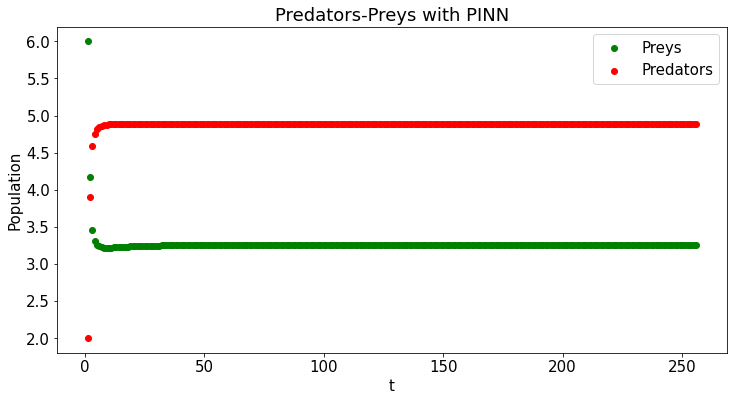

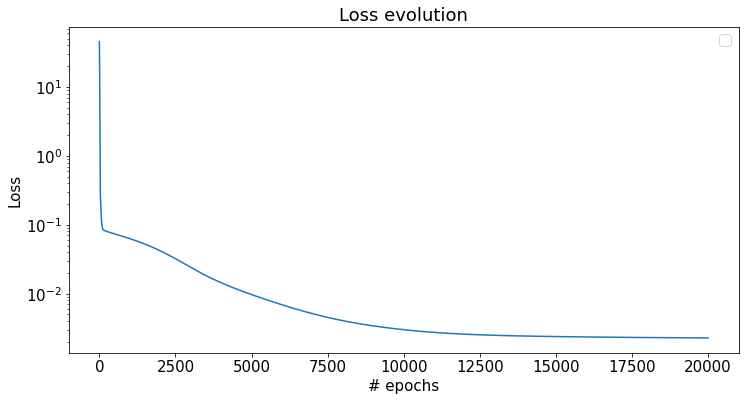

In [ ]:
nn_approximator = NNApproximator(4, 10)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=20_000
)
plot()

Streaming output truncated to the last 5000 lines.
5.998989105224609 6 1.9997695684432983 2 0.006471495144069195 0.006470419932156801 1.0219082469120622e-06 5.309870232395042e-08
5.998990058898926 6 1.9997698068618774 2 0.006470666732639074 0.006469593849033117 1.0199810276390053e-06 5.298888083871134e-08
Epoch: 5000 - Loss: 0.006471
5.998990058898926 6 1.999769687652588 2 0.0064698392525315285 0.0064687663689255714 1.0199810276390053e-06 5.3043777370476164e-08
5.998990058898926 6 1.999769926071167 2 0.0064690131694078445 0.0064679402858018875 1.0199810276390053e-06 5.2934012728655944e-08
5.998989105224609 6 1.999769926071167 2 0.006468191277235746 0.006467116065323353 1.0219082469120622e-06 5.2934012728655944e-08
5.998989582061768 6 1.9997698068618774 2 0.00646736565977335 0.006466291844844818 1.0209444099018583e-06 5.298888083871134e-08
5.998989582061768 6 1.999769926071167 2 0.006466543301939964 0.006465469487011433 1.0209444099018583e-06 5.2934012728655944e-08
5.998989105224609 6 1

5.998931407928467 6 1.9998934268951416 2 0.005003291182219982 0.005002138204872608 1.1418890153436223e-06 1.1357826679159189e-08
5.998931407928467 6 1.9998934268951416 2 0.0050030783750116825 0.0050019253976643085 1.1418890153436223e-06 1.1357826679159189e-08
5.998930931091309 6 1.9998935461044312 2 0.00500286603346467 0.005001712124794722 1.1429083315306343e-06 1.1332431881783123e-08
5.998931884765625 6 1.9998934268951416 2 0.005002651829272509 0.005001499783247709 1.1408701539039612e-06 1.1357826679159189e-08
5.998931407928467 6 1.9998936653137207 2 0.005002439487725496 0.005001286510378122 1.1418890153436223e-06 1.1307065506116487e-08
5.998931407928467 6 1.9998936653137207 2 0.005002226214855909 0.005001073237508535 1.1418890153436223e-06 1.1307065506116487e-08


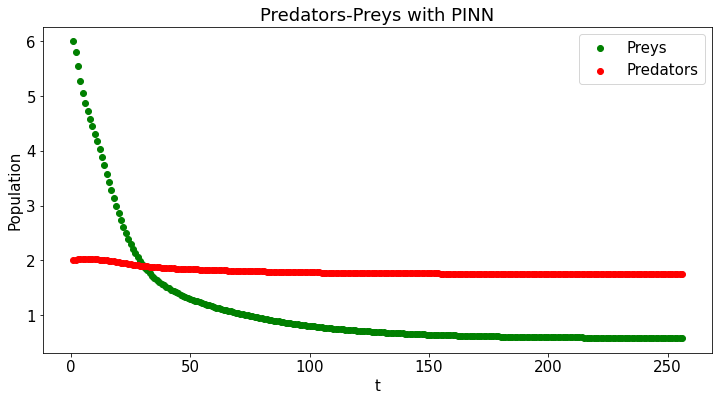

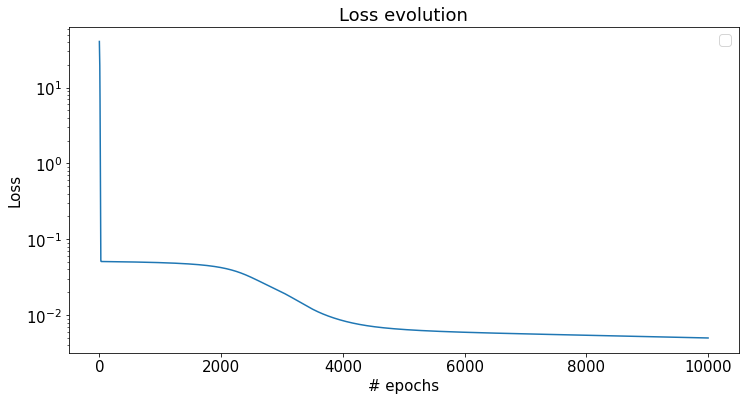

In [ ]:
nn_approximator = NNApproximator(7, 20)
# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.01, max_epochs=10_000
)
plot()